## Densely Connected Convolutional Networks
Paper Link: https://arxiv.org/pdf/1608.06993.pdf

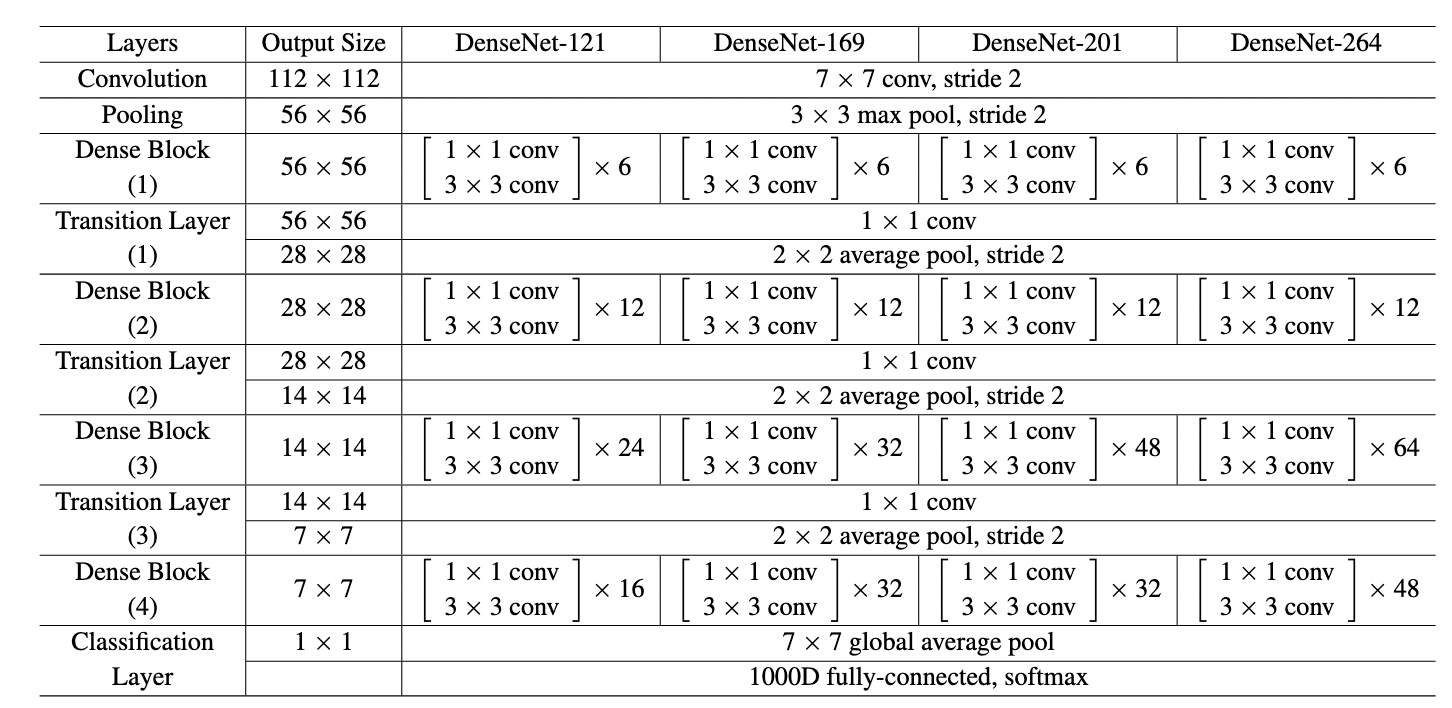

```python
@article{huang2019convolutional,
 title={Convolutional Networks with Dense Connectivity},
 author={Huang, Gao and Liu, Zhuang and Pleiss, Geoff and Van Der Maaten, Laurens and Weinberger, Kilian},
 journal={IEEE Transactions on Pattern Analysis and Machine Intelligence},
 year={2019}
 }
 
@inproceedings{huang2017densely,
  title={Densely Connected Convolutional Networks},
  author={Huang, Gao and Liu, Zhuang and van der Maaten, Laurens and Weinberger, Kilian Q },
  booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition},
  year={2017}
}
```

Other References: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html#DenseNet

### DenseNet Block

![DenseNet](https://www.researchgate.net/publication/331411577/figure/fig1/AS:962661902716930@1606527891405/Illustration-of-a-DenseNet-which-consists-of-four-dense-blocks.png)

__Dense Connectivity__. To further improve the information flow between layers we propose a different connectivity pattern: we introduce direct connections from any layer to all subsequent layers. Consequently, the $\mathcal{l}^{th}$ layer receives the feature maps of all preceeding layers $x_0, x_1, ..., x_{l-1}$ as input:
$$x_l=H_l([x_0, x_1, x_2, ..., x_{l-1}]), \text{eq. 2}$$
where, $[x_0, x_1, x_2, ..., x_{l-1}]$ refers to the __concatenation__ of the feature maps produced by the layers $0, ..., l-1$.

__Composite Function__. $H_l(\cdot)$ is defined as a composite function of three consecutive operations: batch normalization (BN), followed by ReLU and a $3\times 3$ convolutions (Conv).

__Pooling Layer__. The concatenation operation used in eq. 2 is not viable when the size of the feature maps changes. However, an essential part of convolution networks is down-sampling layers that change the size of the feature maps. To facilitate down-sampling in our architecture we divide the network into multiple densely connected _dense blocks_; We refer to the layers between blocks as _transition layers_, which do convolution and pooling. The transition layers used in our experiments consisted of a batch normalization layer and an $1\times1$ conv. layer followed by $2\times2$ average pooling layer.

__Growth rate__. If each function $H_l$ produces $k$ feature maps, it follows that the $l^{th}$ layer ahs $k_0+k\times(l-1)$ input feature maps, where $k_0$ is the number of channels in the input layer. An important difference between DenseNet and other existing architectures is that DenseNet can have very narrow layers e.g. $k=12$. We refer to the hyperparameter as _growth rate_ of the network.
- A relatively small growth can be sufficicient to obtain SOTA results on datasets we tested on. 
    - __Exaplanation__: Each layer has access to all the preceding feature-maps in it's block, and, therefore, to the network's "collective knowledge". One can view the feature maps as the global state of the network. Each layer adds $k$ feature mnaps of its own to this state. The growth reate regulates how much new informatione each layer contributes to global state. The global state, once written, can be accessed from everywhere within the network and, unlike in traditional network architectures, there is no need to replicate it from layer to layer.
    
__Bottleneck layers__. Although each layer only produces $k$ output feature maps, it typically has more inputs. It has been noted that a $1\times1$ convolution can ve introduced as a bottleneck layer before each $3\times3$ convolution to reduce the number of feature maps, and thus to improve computational efficiency. We find this design especially effective for DenseNet and we refer to our network with sych a bottleneck layer _i.e._ to the __BN-ReLU-Conv($1\times1$)-BN-ReLU-Conv($3\times3$)__ version of $H_l$, as DenseNet-B. In our experiments we let, each $1\times1$ convolution to produce $4k$ feature-maps.

__Compression__. To further improve the model compactness, we can reduce the number of feature maps at transition layers. If a dense block contains $m$ feature, we let the following transition layer generate $\lfloor\theta m\rfloor$ output feature maps, where $0<\theta\le1$ as DenseNet-C, and we set $\theta=0.5$ in our experiment. When both the bottleneck and transition layers with $\theta<1$ are used, we refer to our model as DenseNet-BC.

__Implementation Details__. On all datasets except ImageNet, the DenseNet used in our experiments has three dense blocks that each has an equal number of layers. Before entering the first dense block, a convolution with 16 or (twice the growth rate for DenseNet-BC) output channels is performed on the input images. For convolutional layers with kernel size $3\times3$, each side of the inputs is zero padded by one pixel to keep the feature-map size fixed. We use $1\times1$ convolution followed by $2\times2$ average pooling as transition layers between two continuous dense blocks. At the end of the last dense block, a global average pooling is performed than a softmax classifier is attached. The feature-map sizes in the three dense blocks are $32\times32$, $16\times16$ and $8\times8$, respectively. We experiment with basic DenseNet-BC, the networks with configureations $\{L=40, k=12\}$, $\{L=100, k=12\}$ and $\{L=100, k=24\}$. For DenseNet-BC, the network configurations were $\{L=100, k=12\}$, $\{L=250, k=24\}$ and $\{L=190, k=40\}$.

In our experiment with ImageNet, we use a DenseNet-BC structure with 4 dense blocks on $224\times224$ input images. The initial conv. layer comprises of $2k$ convolutions with kernel size $7\times7$ and stride $2;$ the number of feature maps in all other layers also follow from settings $k$. The exact network configurations we used on ImageNet as in the above table.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(f'''TensorFlow: {tf.__version__}
Physical Devices: {physical_devices}''')

TensorFlow: 2.9.2
Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
class _DenseLayer(layers.Layer):
    def __init__(self, c_in, growth):
        super(_DenseLayer, self).__init__()
        self.conv1 = keras.Sequential([
            layers.Conv2D(filters=c_in, kernel_size=1, strides=1, padding='same'), 
            layers.BatchNormalization(), 
            layers.ReLU()
        ])
        
        self.conv2 = keras.Sequential([
            layers.Conv2D(filters=growth, kernel_size=3, strides=1, padding='same'), 
            layers.BatchNormalization(), 
            layers.ReLU(),
        ])
    
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(x)
        return out

In [3]:
layer = _DenseLayer(c_in=32, growth=16)
x = tf.random.normal(shape=(5, 56, 56, 32))
layer(x).shape

Metal device set to: Apple M1


TensorShape([5, 56, 56, 16])

In [4]:
class _DenseBlock(layers.Layer):
    def __init__(self, c_in, growth_rate, num_layers):
        super(_DenseBlock, self).__init__()
        self.layers = []
        for idx in range(num_layers):
            self.layers.append(_DenseLayer(c_in=c_in + idx * growth_rate, growth=growth_rate))
    
    def call(self, x):
        features = x
        for layer in self.layers:
            out = layer(features)
            features = tf.concat([features, out], axis=-1)
        return features

In [5]:
dense = _DenseBlock(c_in=32, growth_rate=16, num_layers=6)
x = tf.random.normal(shape=(5, 56, 56, 32))
dense(x).shape

TensorShape([5, 56, 56, 128])

In [6]:
class TransitionLayer(layers.Layer):
    def __init__(self, c_out):
        super(TransitionLayer, self).__init__()
        self.conv1 = keras.Sequential([
            layers.Conv2D(filters=c_out, kernel_size=1, strides=1, padding='same'), 
            layers.BatchNormalization(), 
            layers.ReLU()
        ])
        
        self.pool = layers.MaxPooling2D(pool_size=(2, 2), strides=2)
    
    def call(self, x):
        x = self.conv1(x)
        return self.pool(x)

In [7]:
class DenseNet(keras.Model):
    def __init__(self, growth_rate=16, repetitions=[6, 6, 6, 6]):
        super(DenseNet, self).__init__()
        self.conv1 = keras.Sequential([
            layers.Conv2D(filters=4*growth_rate, kernel_size=7, strides=2, padding='same'), 
            layers.BatchNormalization(), 
            layers.ReLU(), 
        ])
        
        self.pool = layers.MaxPooling2D((3, 3), strides=2, padding='same')
        
        self.dense = []
        
        c_in = 64
        
        for idx in range(len(repetitions) - 1):
            t = repetitions[idx]
#             print(f'c_in: {c_in}')
            layer = keras.Sequential([
                _DenseBlock(c_in=c_in, growth_rate=growth_rate, num_layers=t), 
                TransitionLayer(c_out=(c_in + t * growth_rate))
            ])
            self.dense.append(layer)
            c_in = (c_in + t * growth_rate)
        
        self.dense.append(_DenseBlock(c_in=c_in, growth_rate=growth_rate, num_layers=repetitions[-1]))
        
        self.avgpool = layers.GlobalAveragePooling2D()
        self.classifier = layers.Dense(units=1000, activation='softmax')
    
    def call(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        for layer in self.dense:
            x = layer(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x
    
    def model(self):
        inp = keras.Input(shape=(224, 224, 3))
        return keras.Model(inp, self.call(inp))

In [8]:
model = DenseNet()
model.model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_14 (Sequential)  (None, 112, 112, 64)      9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 sequential_28 (Sequential)  (None, 28, 28, 160)       189232    
                                                                 
 sequential_42 (Sequential)  (None, 14, 14, 256)       490576    
                                                                 
 sequential_56 (Sequential)  (None, 7, 7, 352)         920944    
                                                             